# LAB 5 - FINANCIAL TIME SERIES

In this lab, you will be given two tasks:

1. Explore and understand code fitting GARCH models to the log-returns of Bitcoin from 2019 to 2024.

2. Choose a different financial index you might be interested in - for instance Amazon (AMZN), Tesla (TSLA), JPMorgan Chase (JPM), Goldman Sachs (GS), American Express (AMX), Capri Holdings (CPRI), Louis Vuitton group (LVMUY), InterContinental Hotel Group (IHG), Delta Airlines (DAL), or any other that you like. Use the code from the previous part to investigate the behaviour of the index. You can also pick the one you have been discussing within your group and start the analysis for the presentation.

## PART 1 - BITCOIN

In this lab you will analyze the evolution of the closing price of Bitcoin using volatility models. To apply them you first need to install the `arch` library. The data is retrieved from `yfinance` which should be already installed in your machine.

In [ ]:
!pip install arch

# DOWNLOADING AND VISUALIZING THE DATA
The following code downloads the closing prices of Bitcoin and computes the percentage log-returns and absolute log-returns (absolute values). It then creates the two time series plots. In the plot of the absolute values you also have a LOESS smoothing of the time series as well as a rolling estimate of the standard deviation of the absolute data.

 1. Is there evidence of volatility clustering? Are there years where the evolution of the prices of Bitcoin was more stable?

 2. Play with the window size of the rolling standard deviation estimate and the `frac` input of the LOESS smoothing. What happens when you vary these parameters?

YF.download() has changed argument auto_adjust default to True


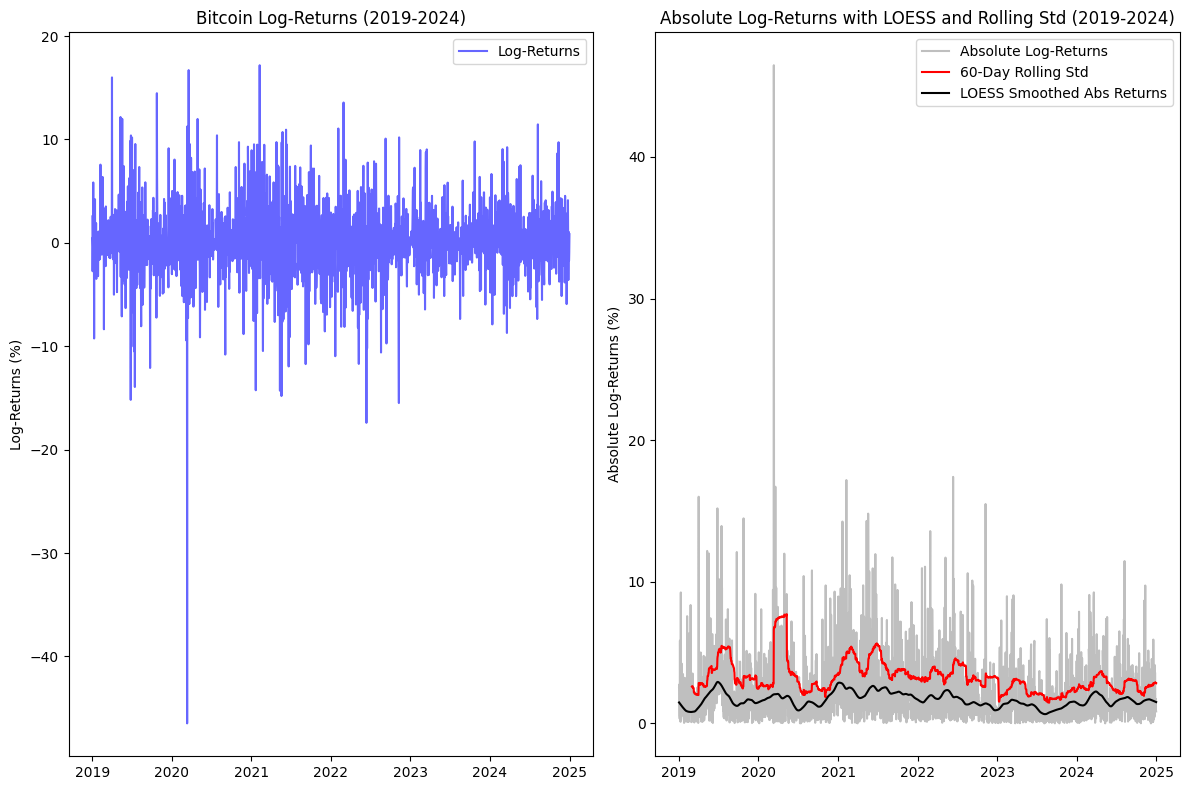

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Fetch Bitcoin data from Yahoo Finance (2019-2024)
btc = yf.download("BTC-USD", start="2019-01-01", end="2025-01-01", progress=False)

# Compute percentage log-returns
btc['Log_Return'] = np.log(btc['Close'] / btc['Close'].shift(1)) * 100
btc.dropna(inplace=True)

# Compute absolute log-returns
btc['Abs_Log_Return'] = np.abs(btc['Log_Return'])

# Compute rolling 60-day standard deviation
btc['Rolling_Std'] = btc['Log_Return'].rolling(window=60).std()

# LOESS smoothing (LOWESS from statsmodels)
lowess = sm.nonparametric.lowess
smoothed_abs = lowess(btc['Abs_Log_Return'], btc.index, frac=0.03)  # frac=0.03 controls smoothness

# Plot time series
fig, axes = plt.subplots(1, 2, figsize=(12, 8), sharex=True)

# Plot log-returns
top_ax = axes[0]
top_ax.plot(btc.index, btc['Log_Return'], color='blue', alpha=0.6, label='Log-Returns')
top_ax.set_ylabel("Log-Returns (%)")
top_ax.set_title("Bitcoin Log-Returns (2019-2024)")
top_ax.legend()

# Plot absolute log-returns with LOESS and rolling std
bottom_ax = axes[1]
bottom_ax.plot(btc.index, btc['Abs_Log_Return'], color='gray', alpha=0.5, label='Absolute Log-Returns')
bottom_ax.plot(btc.index, btc['Rolling_Std'], color='red', label='60-Day Rolling Std')
bottom_ax.plot(btc.index, smoothed_abs[:, 1], color='black', label='LOESS Smoothed Abs Returns')
bottom_ax.set_ylabel("Absolute Log-Returns (%)")
bottom_ax.set_title("Absolute Log-Returns with LOESS and Rolling Std (2019-2024)")
bottom_ax.legend()

plt.tight_layout()
plt.show()

# FITTING A NORMAL DISTRIBUTION
We now forget for a second that the data is a time-series and simply check if overall it follows a Normal distribution. To do this we compute the sample mean, variance, skewness and kurtosis. What do these values tell you?

Furthermore, we plot the histogram of the data with the best Normal line. Does the assumption of Normality holds? To help you, I also report the p-value of a test of Normality (null hypothesis: the data follows a Normal distribution).

Mean: 0.1456
Variance: 11.7436
Skewness: -1.1037
Kurtosis: 18.2806
Normality Test p-value: 0.0000 (Not Normal)


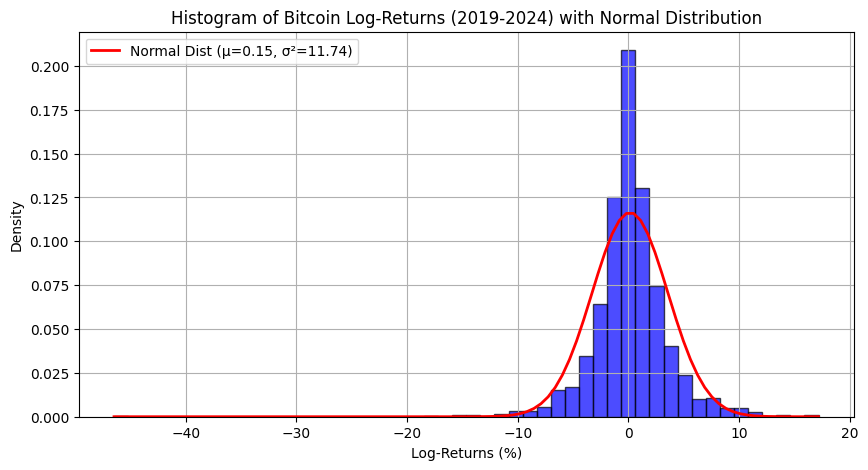

In [2]:
from scipy.stats import skew, kurtosis, normaltest, norm

# Compute statistics
mean_return = np.mean(btc['Log_Return'])
variance_return = np.var(btc['Log_Return'])
skewness_return = skew(btc['Log_Return'])
kurtosis_return = kurtosis(btc['Log_Return'])

# Normality test (D'Agostino and Pearson’s test)
stats_test, p_value = normaltest(btc['Log_Return'])
normality_result = "Normal" if p_value > 0.05 else "Not Normal"

# Print statistics
print(f"Mean: {mean_return:.4f}")
print(f"Variance: {variance_return:.4f}")
print(f"Skewness: {skewness_return:.4f}")
print(f"Kurtosis: {kurtosis_return:.4f}")
print(f"Normality Test p-value: {p_value:.4f} ({normality_result})")

# Plot histogram with overlaid normal distribution
plt.figure(figsize=(10, 5))
count, bins, _ = plt.hist(btc['Log_Return'], bins=50, alpha=0.7, color='blue', edgecolor='black', density=True)

# Compute normal distribution curve
x = np.linspace(bins[0], bins[-1], 100)
pdf = norm.pdf(x, mean_return, np.sqrt(variance_return))
plt.plot(x, pdf, color='red', lw=2, label=f'Normal Dist (μ={mean_return:.2f}, σ²={variance_return:.2f})')

plt.xlabel("Log-Returns (%)")
plt.ylabel("Density")
plt.title("Histogram of Bitcoin Log-Returns (2019-2024) with Normal Distribution")
plt.legend()
plt.grid()
plt.show()

# FITTING A T-DISTRIBUTION
We now repeat the previous step, but now assuming a T-distribution. Interpret the results and parameter estimates. Does a T-distribution provide a better description of the data?

Fitted t-distribution parameters:
Degrees of Freedom: 2.4853
Location: 0.1105
Scale: 1.9331
Variance: 19.1373
Kurtosis: Infinite


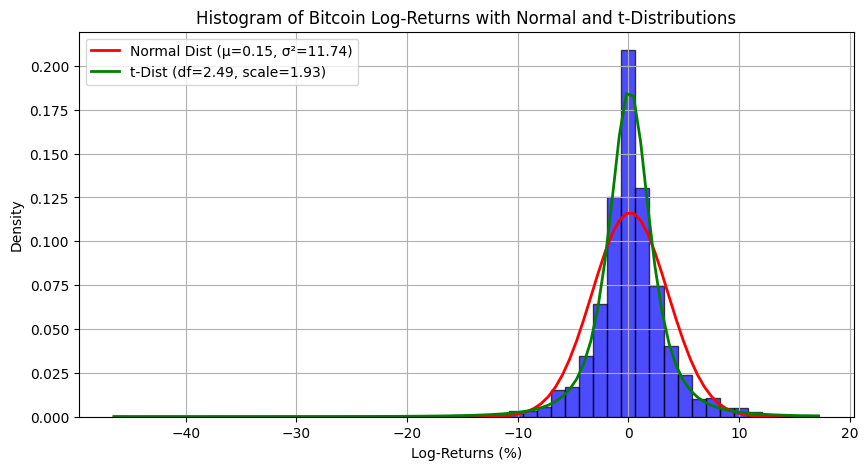

In [3]:
from scipy.stats import t

# Fit a t-distribution to the log-returns
params = t.fit(btc['Log_Return'])  # Direct fitting

# Extract fitted parameters
df_t, loc_t, scale_t = params

# Compute variance and kurtosis of the fitted t-distribution
variance_t = (df_t / (df_t - 2)) * (scale_t ** 2) if df_t > 2 else np.nan
kurtosis_t = (6 / (df_t - 4)) if df_t > 4 else np.inf  # Infinite for df <= 4

# Print fitted parameters and statistics
print(f"Fitted t-distribution parameters:")
print(f"Degrees of Freedom: {df_t:.4f}")
print(f"Location: {loc_t:.4f}")
print(f"Scale: {scale_t:.4f}")
print(f"Variance: {variance_t:.4f}")
print(f"Kurtosis: {'Infinite' if np.isinf(kurtosis_t) else f'{kurtosis_t:.4f}'}")

# Plot histogram with normal and t-distribution curves
plt.figure(figsize=(10, 5))
count, bins, _ = plt.hist(btc['Log_Return'], bins=50, alpha=0.7, color='blue', edgecolor='black', density=True)

# Compute normal and t-distribution curves
x = np.linspace(bins[0], bins[-1], 100)
pdf_norm = norm.pdf(x, np.mean(btc['Log_Return']), np.std(btc['Log_Return']))
pdf_t = t.pdf(x, df_t, loc=loc_t, scale=scale_t)

plt.plot(x, pdf_norm, color='red', lw=2, label=f'Normal Dist (μ={np.mean(btc["Log_Return"]):.2f}, σ²={np.var(btc["Log_Return"]):.2f})')
plt.plot(x, pdf_t, color='green', lw=2, label=f't-Dist (df={df_t:.2f}, scale={scale_t:.2f})')

plt.xlabel("Log-Returns (%)")
plt.ylabel("Density")
plt.title("Histogram of Bitcoin Log-Returns with Normal and t-Distributions")
plt.legend()
plt.grid()
plt.show()


# FITTING A GARCH MODEL
We now move on to modeling. In the case of AR + GARCH models we could of course do some grid search of the best combination of parameters. However, usually the number of models that are worth considering is small and can be explored manually.

Here I chose for Bitcoin an AR(1) + GARCH(1,1) model with a t-distribution for the errors. Look at the output and intepret the parameter estimates.

Also I suggest you try different models.

 - For instance set `dist = 'normal'` which would assume a Normal distribution for the errors;

 - Try considering a GJR-GARCH(1,1,1) model by setting `o = 1`;

 - Look at ARCH models setting `q=0` and varying the input parameter `p`.

 The code also produces the standard `arch` output for you.


Model Summary:
                              AR - GARCH Model Results                              
Dep. Variable:                   Log_Return   R-squared:                       0.002
Mean Model:                              AR   Adj. R-squared:                  0.002
Vol Model:                            GARCH   Log-Likelihood:               -5410.98
Distribution:      Standardized Student's t   AIC:                           10834.0
Method:                  Maximum Likelihood   BIC:                           10868.1
                                              No. Observations:                 2190
Date:                      Thu, Mar 13 2025   Df Residuals:                     2188
Time:                              17:03:01   Df Model:                            2
                                    Mean Model                                   
                    coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------

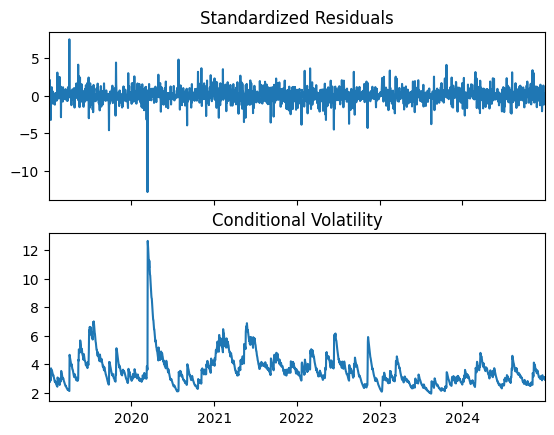

In [4]:
from arch import arch_model

from statsmodels.tsa.arima.model import ARIMA

# Prepare the data
returns = btc['Log_Return'].dropna()

# Fit GARCH(1,1) model with t-distributed errors
garch_model = arch_model(returns, mean = 'AR', lags= 1, vol='Garch', p=1, o=0, q=1, dist='t')
garch_fit = garch_model.fit(disp='off')
print("\nModel Summary:")
print(garch_fit.summary())

# Plot GJR-GARCH model results
fig = garch_fit.plot()
plt.show()

# VISUALIZING VOLATILITY

The following code creates two plots that are commonly created in finance to visualize the volatility of financial data.

  1. The log-return series with a ribbon of +/- 2 standard deviations (dynamic)

  2. The absolute log-returns with the standard deviation (also dynamic)

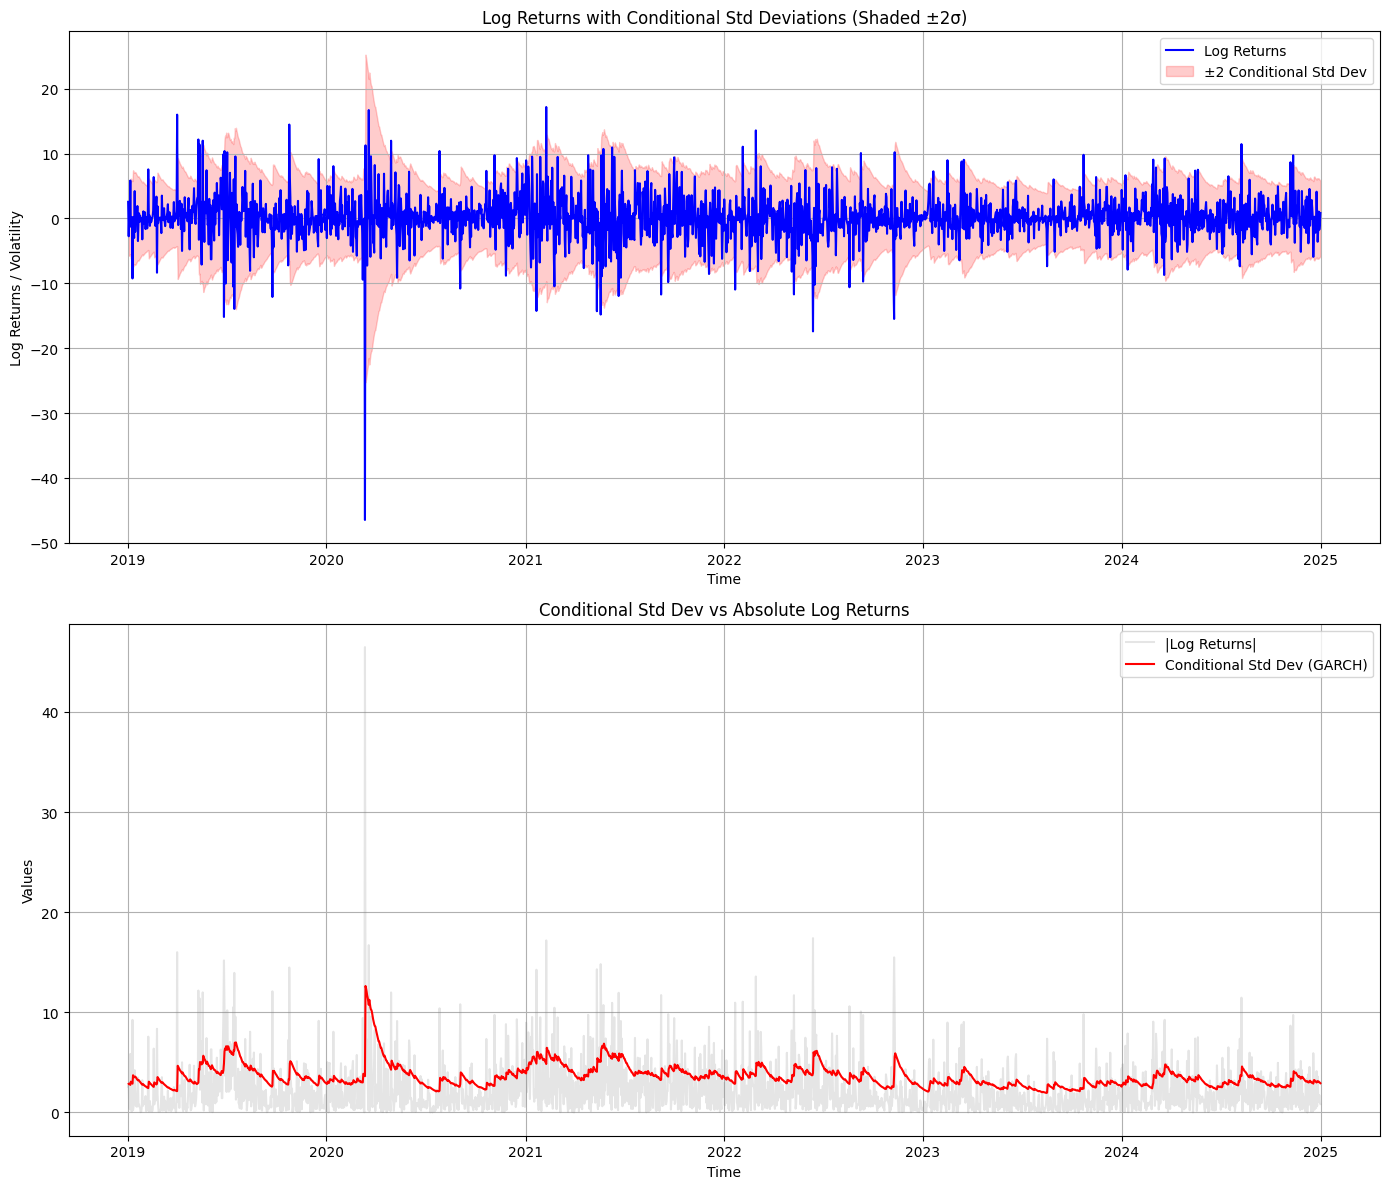

In [5]:
# Get the conditional volatility (sigma_t) and standardized residuals
conditional_volatility = garch_fit.conditional_volatility
absolute_log_returns = np.abs(returns)

# Combined plot with two subplots stacked vertically
fig, axs = plt.subplots(2, 1, figsize=(14, 12))

# Plot 1: Log returns with shaded ±2 conditional standard deviations
axs[0].plot(returns, label='Log Returns', color='blue')
upper_bound = 2 * conditional_volatility
lower_bound = -2 * conditional_volatility
axs[0].fill_between(btc.index, lower_bound, upper_bound, color='red', alpha=0.2, label='±2 Conditional Std Dev')
axs[0].set_title('Log Returns with Conditional Std Deviations (Shaded ±2σ)')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Log Returns / Volatility')
axs[0].legend()
axs[0].grid(True)

# Plot 2: Conditional Std Dev vs. Absolute Log Returns
axs[1].plot(absolute_log_returns, label='|Log Returns|', color='gray', alpha=0.2)
axs[1].plot(conditional_volatility, label='Conditional Std Dev (GARCH)', color='red')
axs[1].set_title('Conditional Std Dev vs Absolute Log Returns')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Values')
axs[1].legend()
axs[1].grid(True)

# Adjust layout and save the figure
plt.tight_layout()
plt.show()

# RESIDUAL ANALYSIS

Is the model appropriate for the data? The following code constructs the visualizations we have been using throughout this course to see if there are still patterns in the data that our model did not describe. Interpret all the plots below.

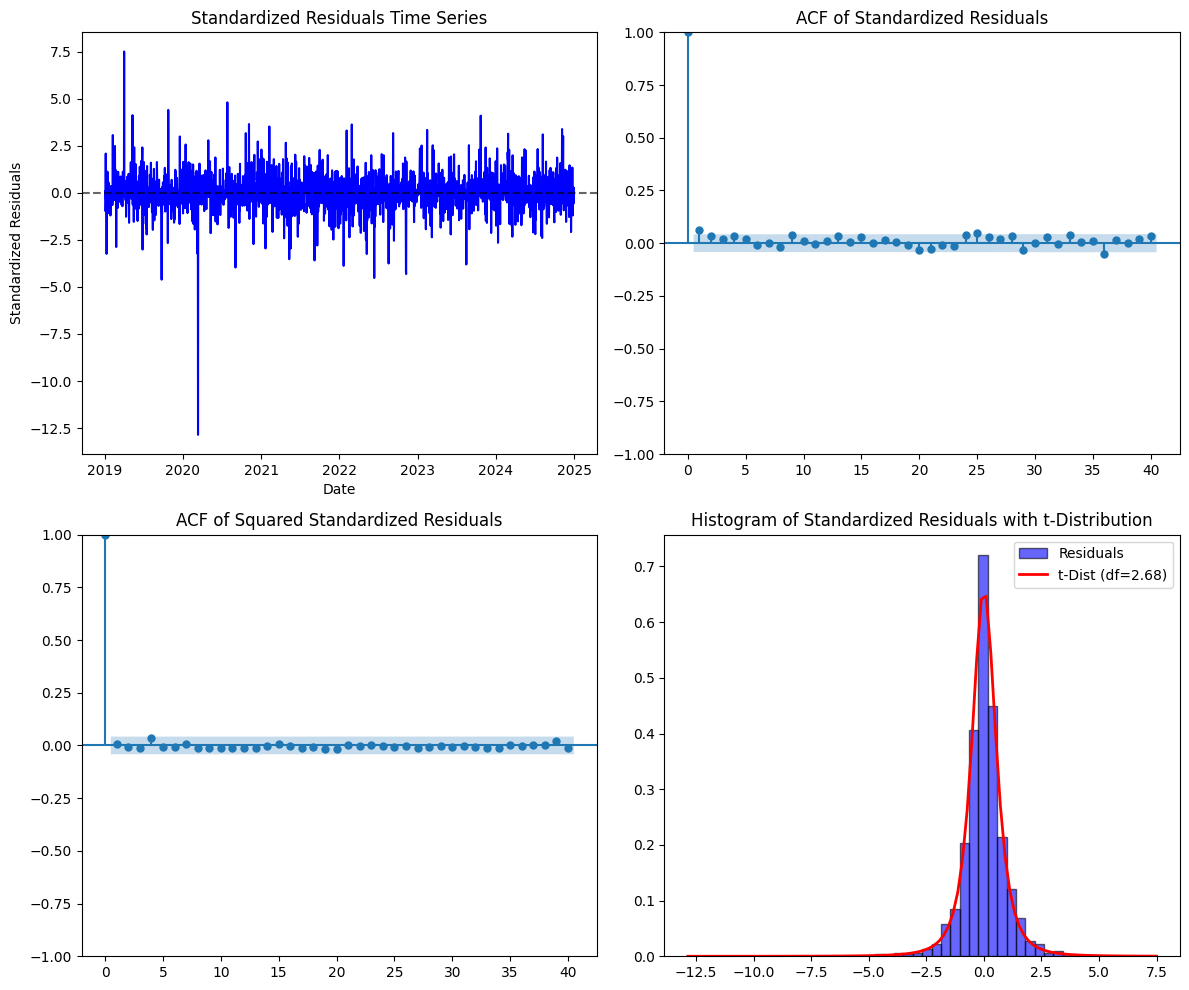

In [6]:
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t, probplot

# Compute standardized residuals
std_residuals = garch_fit.resid / garch_fit.conditional_volatility
std_residuals = std_residuals.dropna()

# Set up 2x2 residual plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Standardized residual time series
sns.lineplot(x=std_residuals.index, y=std_residuals, ax=axes[0, 0], color='blue')
axes[0, 0].set_title("Standardized Residuals Time Series")
axes[0, 0].set_ylabel("Standardized Residuals")
axes[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.6)

# 2. ACF of standardized residuals
plot_acf(std_residuals, ax=axes[0, 1], lags=40)
axes[0, 1].set_title("ACF of Standardized Residuals")

# 3. ACF of squared standardized residuals
plot_acf(std_residuals**2, ax=axes[1, 0], lags=40)
axes[1, 0].set_title("ACF of Squared Standardized Residuals")

# 4. QQ-plot with estimated t-distribution
df_t, loc_t, scale_t = t.fit(std_residuals)
x = np.linspace(min(std_residuals), max(std_residuals), 100)
pdf_t = t.pdf(x, df_t, loc=loc_t, scale=scale_t)

axes[1, 1].hist(std_residuals, bins=50, density=True, alpha=0.6, color='blue', edgecolor='black', label="Residuals")
axes[1, 1].plot(x, pdf_t, color='red', lw=2, label=f't-Dist (df={df_t:.2f})')
axes[1, 1].set_title("Histogram of Standardized Residuals with t-Distribution")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# RISK MODELING - VaR ESTIMATES

Let's assume once more that the data is not a time series and let's compute non-dynamic estimates of the Value-at-Risk. The following code does a comprehensive of VaR.

  1. It computes VaR for many possible levels (x-axis of the plot)
  2. It considers the three approaches we have seen in class - historical; Normal distribution; T-distribution
  3. It plots the VaR (y-axis) of the three methods for different levels.

Of course in reality, it would be preferable to only use the T-distribution estimate, but here I show you all to compare the results.

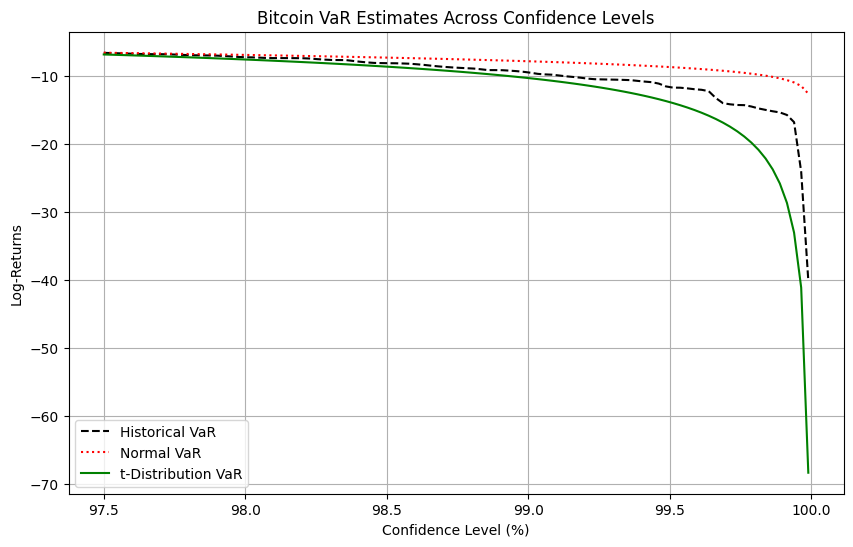

In [7]:
# Prepare the data
returns = btc['Log_Return'].dropna()

# Confidence levels for VaR
confidence_levels = np.linspace(0.975, 0.9999, 100)

# Compute VaR for different confidence levels
VaR_hist = [np.percentile(returns, (1 - alpha) * 100) for alpha in confidence_levels]
VaR_norm = [norm.ppf(1 - alpha, loc=np.mean(returns), scale=np.std(returns)) for alpha in confidence_levels]
df_t, loc_t, scale_t = t.fit(returns)
VaR_t = [loc_t + scale_t * t.ppf(1 - alpha, df_t) for alpha in confidence_levels]

# Plot VaR estimates as a function of confidence level
plt.figure(figsize=(10, 6))
plt.plot(confidence_levels * 100, VaR_hist, label='Historical VaR', linestyle='dashed', color='black')
plt.plot(confidence_levels * 100, VaR_norm, label='Normal VaR', linestyle='dotted', color='red')
plt.plot(confidence_levels * 100, VaR_t, label='t-Distribution VaR', linestyle='solid', color='green')

plt.xlabel("Confidence Level (%)")
plt.ylabel("Log-Returns")
plt.title("Bitcoin VaR Estimates Across Confidence Levels")
plt.legend()
plt.grid()
plt.show()

# RISK MANAGEMENT - EXPECTED SHORTFALL
The following code creates the same plot as above, but now for ES.

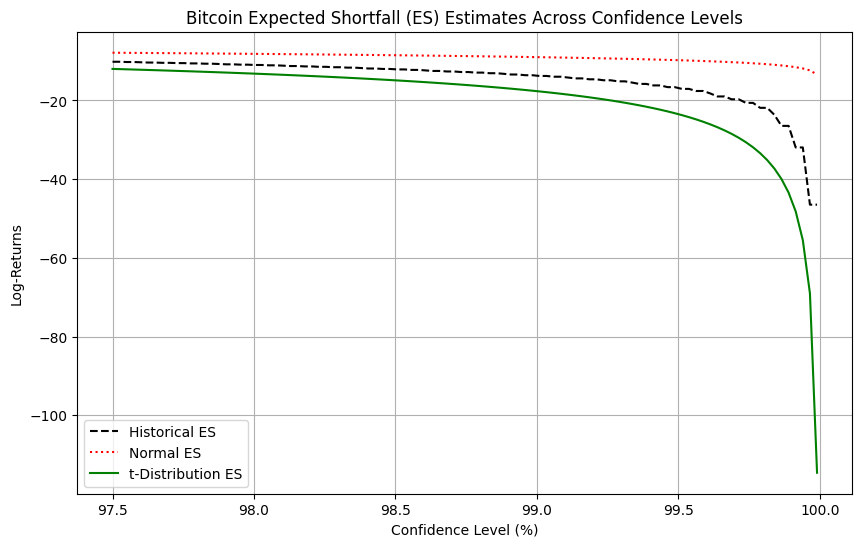

In [8]:
# Compute Expected Shortfall (ES) using the proper formulas
mean_return, std_return = returns.mean(), returns.std()
phi_norm = norm.pdf(norm.ppf(confidence_levels))
ES_norm = mean_return - std_return * (phi_norm / (1 - confidence_levels))

# Compute t-Distribution Expected Shortfall
t_alpha = t.ppf(confidence_levels, df_t)
t_pdf_alpha = t.pdf(t_alpha, df_t)
ES_t = loc_t - scale_t * (t_pdf_alpha / (1 - confidence_levels)) * (df_t + t_alpha**2) / (df_t - 1)

# Compute Historical Expected Shortfall (ES) directly from data
ES_hist = [returns[returns <= VaR_hist[i]].mean() for i in range(len(confidence_levels))]

# Plot Expected Shortfall (ES) estimates as a function of confidence level
plt.figure(figsize=(10, 6))
plt.plot(confidence_levels * 100, ES_hist, label='Historical ES', linestyle='dashed', color='black')
plt.plot(confidence_levels * 100, ES_norm, label='Normal ES', linestyle='dotted', color='red')
plt.plot(confidence_levels * 100, ES_t, label='t-Distribution ES', linestyle='solid', color='green')
plt.xlabel("Confidence Level (%)")
plt.ylabel("Log-Returns")
plt.title("Bitcoin Expected Shortfall (ES) Estimates Across Confidence Levels")
plt.legend()
plt.grid()
plt.show()

# DYNAMIC RISK MODELING

As a final step, we compute VaR estimates for our historical data in a dynamic fashion using our GARCH model. The following code creates a plot of the dynamic VaR at each time point. Notice that in this plot we show the negative log-returns as customary (simply positive values are now losses).

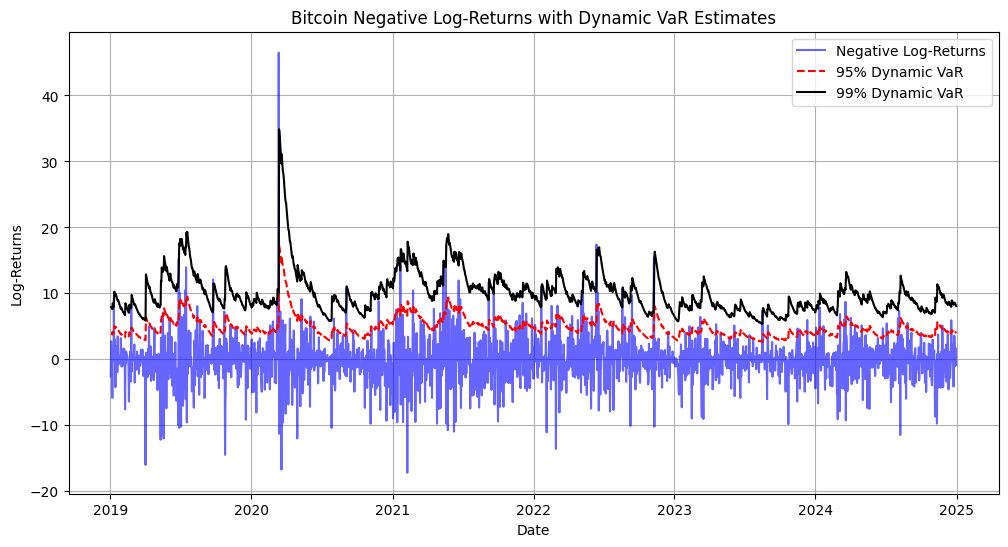

In [9]:
# Extract conditional volatility and standardized residuals
std_residuals = garch_fit.resid / garch_fit.conditional_volatility
std_residuals = std_residuals.dropna()
cond_volatility = garch_fit.conditional_volatility.dropna()

# Fit t-distribution to standardized residuals
df_t, loc_t, scale_t = t.fit(std_residuals)

# Compute dynamic VaR at 95% and 99%
VaR_95 = -scale_t * t.ppf(0.05, df_t) * cond_volatility
VaR_99 = -scale_t * t.ppf(0.01, df_t) * cond_volatility

# Plot time series of negative log-returns with dynamic VaR
plt.figure(figsize=(12, 6))
plt.plot(-returns, label="Negative Log-Returns", color='blue', alpha=0.6)
plt.plot(VaR_95, label="95% Dynamic VaR", linestyle='dashed', color='red')
plt.plot(VaR_99, label="99% Dynamic VaR", linestyle='solid', color='black')

plt.xlabel("Date")
plt.ylabel("Log-Returns")
plt.title("Bitcoin Negative Log-Returns with Dynamic VaR Estimates")
plt.legend()
plt.grid()
plt.show()

# PART 2 - CHOOSE YOUR FINANCIAL INDEX!

You are now free to investigate any time series that you like. You can compare the results with the ones we observed with bitcoin.